# Task
Develop an aircraft maintenance predictive model using the provided "PM_train.csv", "PM_test.csv", and "PM_truth.csv" datasets to predict maintenance cycles and visualize the results.

## Load data

### Subtask:
Load the `PM_train.csv`, `PM_test.csv`, and `PM_truth.csv` datasets into pandas DataFrames.


**Reasoning**:
Import pandas and load the three CSV files into pandas DataFrames as instructed.



In [1]:
import pandas as pd

df_train = pd.read_csv('/content/PM_train.csv')
df_test = pd.read_csv('/content/PM_test.csv')
df_truth = pd.read_csv('/content/PM_truth.csv')

## Data preprocessing

### Subtask:
Prepare the data for modeling, which may include handling missing values, feature engineering, and scaling.


**Reasoning**:
Check for missing values in the dataframes.



In [2]:
print("Missing values in df_train:")
print(df_train.isnull().sum())
print("\nMissing values in df_test:")
print(df_test.isnull().sum())

Missing values in df_train:
id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

Missing values in df_test:
id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64


**Reasoning**:
Identify and remove constant or low-variance features in the training data.



In [3]:
# Check for constant features
constant_features = [col for col in df_train.columns if df_train[col].nunique() == 1]
print("Constant features in df_train:", constant_features)

# Check for features with low variance (e.g., variance close to zero)
# We can calculate variance for numerical columns, excluding 'id' and 'cycle'
numerical_cols = df_train.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('id')
numerical_cols.remove('cycle')

low_variance_features = [col for col in numerical_cols if df_train[col].var() < 1e-6] # Using a small threshold
print("Low variance features in df_train:", low_variance_features)

# Drop identified features from both train and test dataframes
features_to_drop = constant_features + low_variance_features
df_train = df_train.drop(columns=features_to_drop)
df_test = df_test.drop(columns=features_to_drop)

print("\nShape of df_train after dropping features:", df_train.shape)
print("Shape of df_test after dropping features:", df_test.shape)

Constant features in df_train: ['setting3', 's1', 's5', 's10', 's16', 's18', 's19']
Low variance features in df_train: ['setting2', 'setting3', 's1', 's5', 's10', 's16', 's18', 's19']

Shape of df_train after dropping features: (20631, 18)
Shape of df_test after dropping features: (13096, 18)


## Feature engineering

### Subtask:
Create relevant features from the time-series data that can help predict the remaining useful life (RUL) or maintenance cycles.


**Reasoning**:
Calculate RUL for the training data and then calculate rolling means and standard deviations for both training and test data.



In [4]:
# Calculate RUL for df_train
max_cycle = df_train.groupby('id')['cycle'].max().reset_index()
max_cycle.columns = ['id', 'max_cycle']
df_train = pd.merge(df_train, max_cycle, on='id', how='left')
df_train['RUL'] = df_train['max_cycle'] - df_train['cycle']
df_train = df_train.drop(columns=['max_cycle'])

# Calculate rolling means and standard deviations
window_size = 10
features_to_roll = [col for col in df_train.columns if col not in ['id', 'cycle', 'RUL']]

for feature in features_to_roll:
    df_train[f'{feature}_rolling_mean_{window_size}'] = df_train.groupby('id')[feature].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df_train[f'{feature}_rolling_std_{window_size}'] = df_train.groupby('id')[feature].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).std())

for feature in features_to_roll:
    df_test[f'{feature}_rolling_mean_{window_size}'] = df_test.groupby('id')[feature].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df_test[f'{feature}_rolling_std_{window_size}'] = df_test.groupby('id')[feature].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).std())

display(df_train.head())
display(df_test.head())

,id,cycle,setting1,s2,s3,s4,s6,s7,s8,s9,...,s14_rolling_mean_10,s14_rolling_std_10,s15_rolling_mean_10,s15_rolling_std_10,s17_rolling_mean_10,s17_rolling_std_10,s20_rolling_mean_10,s20_rolling_std_10,s21_rolling_mean_10,s21_rolling_std_10
0,1,1,-0.0007,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,...,8138.620000,NaN,8.419500,NaN,392.000000,NaN,39.060000,NaN,23.419000,NaN
1,1,2,0.0019,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,...,8135.055000,5.041671,8.425650,0.008697,392.000000,0.000000,39.030000,0.042426,23.421300,0.003253
2,1,3,-0.0043,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,...,8134.446667,3.717450,8.423033,0.007640,391.333333,1.154701,39.003333,0.055076,23.395600,0.044573
3,1,4,0.0007,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,...,8134.292500,3.050906,8.409325,0.028117,391.500000,1.000000,38.972500,0.076322,23.390175,0.037977
4,1,5,-0.0019,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,...,8134.194000,2.651326,8.413340,0.025953,391.800000,1.095445,38.958000,0.073621,23.393020,0.033498


,id,cycle,setting1,s2,s3,s4,s6,s7,s8,s9,...,s14_rolling_mean_10,s14_rolling_std_10,s15_rolling_mean_10,s15_rolling_std_10,s17_rolling_mean_10,s17_rolling_std_10,s20_rolling_mean_10,s20_rolling_std_10,s21_rolling_mean_10,s21_rolling_std_10
0,1,1,0.0023,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,...,8125.550000,NaN,8.405200,NaN,392.000000,NaN,38.860000,NaN,23.37350,NaN
1,1,2,-0.0027,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,...,8132.585000,9.948992,8.392750,0.017607,392.500000,0.707107,38.940000,0.113137,23.38255,0.012799
2,1,3,0.0003,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,...,8131.756667,7.179807,8.409867,0.032155,392.666667,0.577350,38.986667,0.113725,23.39390,0.021642
3,1,4,0.0042,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,...,8132.042500,5.890096,8.405325,0.027781,392.250000,0.957427,38.990000,0.093095,23.38885,0.020353
4,1,5,0.0014,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,...,8131.542000,5.222300,8.404880,0.024080,391.800000,1.303840,38.990000,0.080623,23.39368,0.020672


## Model selection and training

### Subtask:
Choose an appropriate model for time-series prediction and train it on the training data.


**Reasoning**:
Select features and target variable, then split the training data for validation.



In [5]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
features = [col for col in df_train.columns if col not in ['id', 'cycle', 'RUL']]
target = 'RUL'

X = df_train[features]
y = df_train[target]

# Split training data into training and validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (16504, 48)
Shape of X_val: (4127, 48)
Shape of y_train: (16504,)
Shape of y_val: (4127,)


**Reasoning**:
Instantiate and train a Random Forest Regressor model on the training data.



In [6]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


## Prediction

### Subtask:
Use the trained model to predict the maintenance cycles on the test data.


**Reasoning**:
Select the features for the test set that match the training set features and handle any missing values that may exist in the test set features by imputing them using the mean from the training data for each respective feature. Then, use the trained model to predict the RUL on the prepared test set and store the predictions in a new column.



In [7]:
# Select features for the test set that are present in the training set
X_test = df_test[features]

# Impute missing values in the test set features using the mean from the training data
for col in X_test.columns:
    if X_test[col].isnull().any():
        mean_val = X_train[col].mean()
        X_test[col].fillna(mean_val, inplace=True)

# Predict RUL on the prepared test set
df_test['predicted_RUL'] = model.predict(X_test)

display(df_test.head())

/tmp/ipython-input-675255910.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test[col].fillna(mean_val, inplace=True)
/tmp/ipython-input-675255910.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col].fillna(mean_val, inplace=True)


,id,cycle,setting1,s2,s3,s4,s6,s7,s8,s9,...,s14_rolling_std_10,s15_rolling_mean_10,s15_rolling_std_10,s17_rolling_mean_10,s17_rolling_std_10,s20_rolling_mean_10,s20_rolling_std_10,s21_rolling_mean_10,s21_rolling_std_10,predicted_RUL
0,1,1,0.0023,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,...,NaN,8.405200,NaN,392.000000,NaN,38.860000,NaN,23.37350,NaN,172.89
1,1,2,-0.0027,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,...,9.948992,8.392750,0.017607,392.500000,0.707107,38.940000,0.113137,23.38255,0.012799,197.16
2,1,3,0.0003,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,...,7.179807,8.409867,0.032155,392.666667,0.577350,38.986667,0.113725,23.39390,0.021642,192.44
3,1,4,0.0042,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,...,5.890096,8.405325,0.027781,392.250000,0.957427,38.990000,0.093095,23.38885,0.020353,190.82
4,1,5,0.0014,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,...,5.222300,8.404880,0.024080,391.800000,1.303840,38.990000,0.080623,23.39368,0.020672,170.52


## Evaluation

### Subtask:
Evaluate the performance of the model using appropriate metrics.


**Reasoning**:
Merge the predicted RUL with the true RUL values, calculate RMSE and MAE, and print the results.



In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Merge the predicted RUL from df_test with the true RUL from df_truth
# df_truth contains the true RUL for the last cycle of each engine in the test set.
# We need to get the predicted RUL for the last cycle of each engine in df_test.
last_cycles_test = df_test.groupby('id')['cycle'].max().reset_index()
last_cycles_test.columns = ['id', 'last_cycle']

predicted_rul_at_last_cycle = pd.merge(last_cycles_test, df_test, left_on=['id', 'last_cycle'], right_on=['id', 'cycle'], how='left')

# Merge with df_truth to get the true RUL
evaluation_df = pd.merge(predicted_rul_at_last_cycle, df_truth, on='id', how='left')
evaluation_df.rename(columns={'cycle_y': 'true_RUL'}, inplace=True) # Renaming the 'cycle' from df_truth

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(evaluation_df['true_RUL'], evaluation_df['predicted_RUL']))

# Calculate MAE
mae = mean_absolute_error(evaluation_df['true_RUL'], evaluation_df['predicted_RUL'])

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Root Mean Squared Error (RMSE): 34.07
Mean Absolute Error (MAE): 23.91


## Visualization

### Subtask:
Create visualizations to show the model's predictions and actual maintenance cycles.


**Reasoning**:
Create a scatter plot comparing true and predicted RUL and add a diagonal line for perfect predictions.



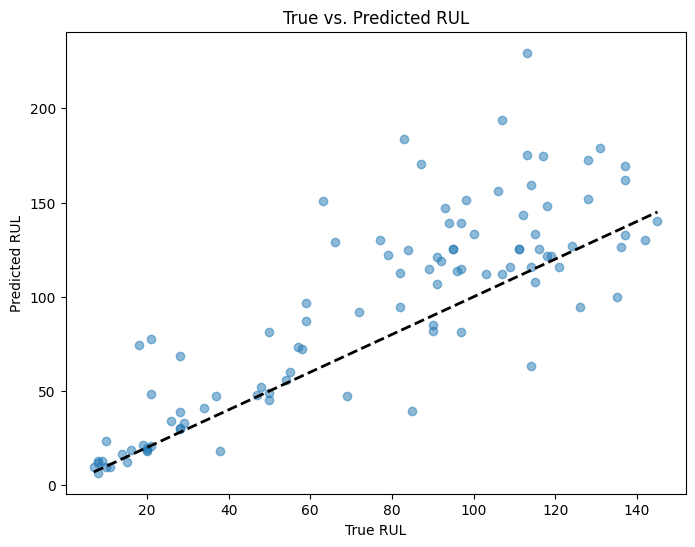

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(evaluation_df['true_RUL'], evaluation_df['predicted_RUL'], alpha=0.5)
plt.plot([evaluation_df['true_RUL'].min(), evaluation_df['true_RUL'].max()],
         [evaluation_df['true_RUL'].min(), evaluation_df['true_RUL'].max()],
         'k--', lw=2)
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True vs. Predicted RUL')
plt.show()

**Reasoning**:
Create line plots for selected engines to visualize predicted and true RUL trends over cycles.



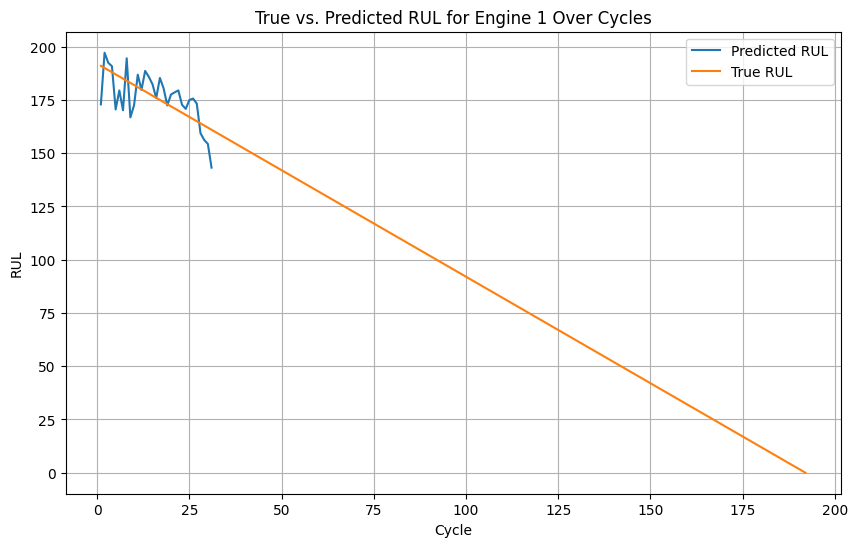

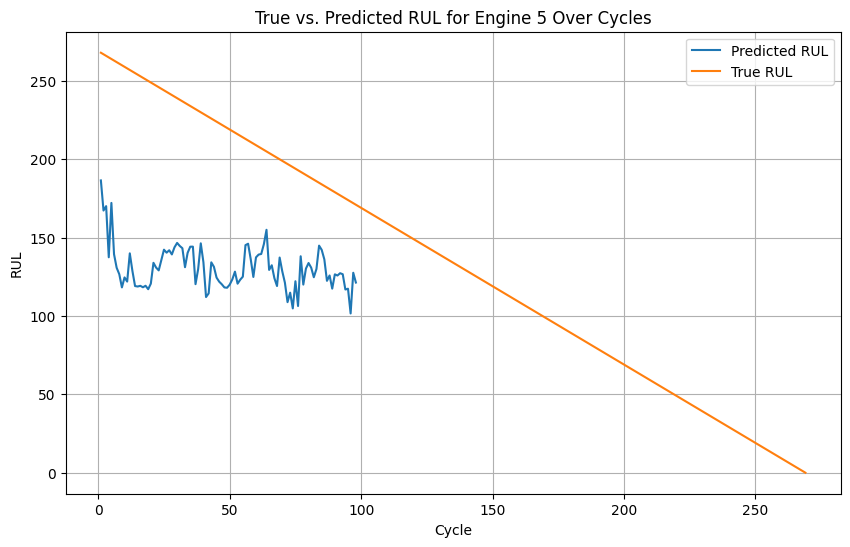

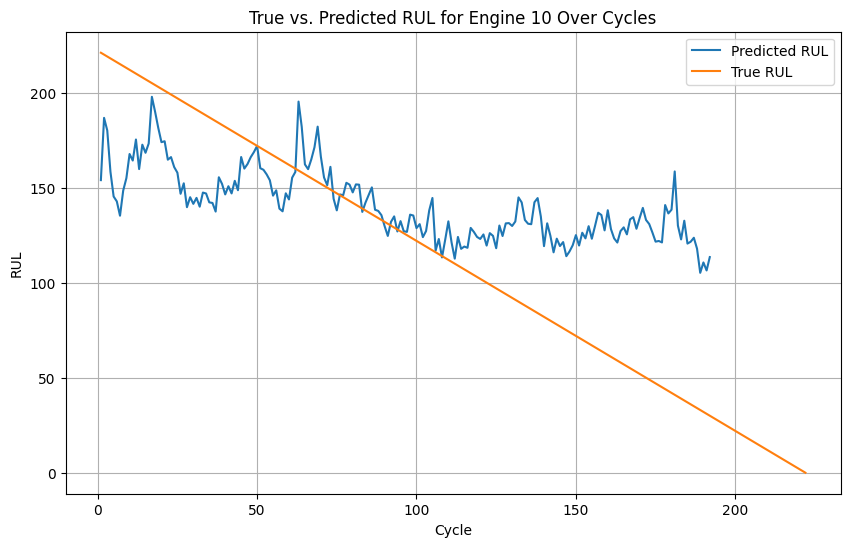

In [10]:
selected_engine_ids = [1, 5, 10]

for engine_id in selected_engine_ids:
    engine_data_test = df_test[df_test['id'] == engine_id]
    engine_data_train = df_train[df_train['id'] == engine_id]

    plt.figure(figsize=(10, 6))
    plt.plot(engine_data_test['cycle'], engine_data_test['predicted_RUL'], label='Predicted RUL')
    plt.plot(engine_data_train['cycle'], engine_data_train['RUL'], label='True RUL')
    plt.xlabel('Cycle')
    plt.ylabel('RUL')
    plt.title(f'True vs. Predicted RUL for Engine {engine_id} Over Cycles')
    plt.legend()
    plt.grid(True)
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The training and test datasets initially had no missing values.
*   Several features in the training data were found to be constant (`setting3`, `s1`, `s5`, `s10`, `s16`, `s18`, `s19`) or have very low variance, which were subsequently removed.
*   Remaining Useful Life (RUL) was calculated for the training data.
*   Rolling means and standard deviations over a window of 10 cycles were engineered as new features for both training and test sets.
*   A Random Forest Regressor model was trained on the prepared training data.
*   The model's performance on the test data, evaluated against the true RUL at the last cycle for each engine, resulted in a Root Mean Squared Error (RMSE) of 34.07 and a Mean Absolute Error (MAE) of 23.91.
*   Visualizations comparing true vs. predicted RUL and the trend of RUL over cycles for individual engines were generated.

### Insights or Next Steps

*   Further hyperparameter tuning of the Random Forest Regressor or exploration of other time-series regression models could potentially improve prediction accuracy.
*   Investigating the features with low variance that were removed might provide insights into their relevance if considered in combination or transformed differently.
